In [1]:
# Import manipulating files libraries
import os, glob
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU

# Import graph/image plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Import loading and manipulating neuroimaging data library
import nibabel as nib

# Import array manipulating libraries
import numpy as np
import pandas as pd

# Import deep learning model libraries
import tensorflow as tf
import keras
from keras.callbacks import TensorBoard
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization

from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Import date/time library to save models with date/time
from datetime import datetime
from tensorflow.keras.regularizers import l2

In [2]:
# Load the data from the .npy file
data_con = np.load('non_dyslexic_data.npy')

# Print the loaded data
print(data_con.shape)

(5310, 64, 64)


(64, 64)


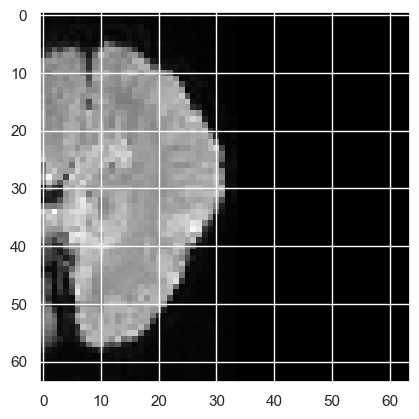

In [3]:
# Generate a random 2D numpy array
img = data_con[5200]
print(img.shape)

# Plot the image using matplotlib
plt.imshow(img, cmap='gray')

# Show the plot
plt.show()

In [4]:
# Load the data from the .npy file
data_dys = np.load('dyslexic_data.npy')

# Print the loaded data
print(data_dys.shape)

(5310, 64, 64)


(64, 64)


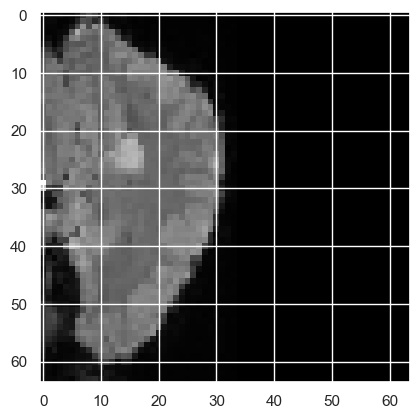

In [5]:
# Generate a random 2D numpy array
img1 = data_dys[5200]
print(img1.shape)

# Plot the image using matplotlib
plt.imshow(img1, cmap='gray')

# Show the plot
plt.show()

In [6]:
concatenated_array = np.concatenate((data_dys, data_con))

# print the concatenated array
print(concatenated_array.shape)

(10620, 64, 64)


(64, 64)


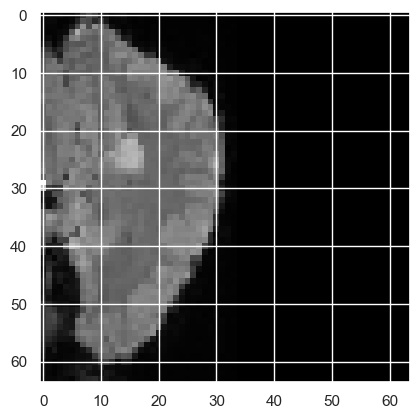

In [7]:
# Generate a random 2D numpy array
img2 = concatenated_array[5200]
print(img2.shape)

# Plot the image using matplotlib
plt.imshow(img2, cmap='gray')

# Show the plot
plt.show()

In [8]:
print(img1 == img2)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [9]:
# Get the labels for our data from our csv file
Labels = pd.read_csv('labeled_data.csv')
# Define our target from the column "Labels" as our y in our model
target = Labels['Label']

In [10]:
# Add a fourth dimension with a value of 3
concatenated_array = np.expand_dims(concatenated_array, axis=-1)
full_data = np.repeat(concatenated_array, 3, axis=-1)

# The resulting shape of arr will be (120, 4096, 4096, 3)
print(full_data.shape)

(10620, 64, 64, 3)


In [11]:
target.head

<bound method NDFrame.head of 0        0
1        0
2        0
3        0
4        0
        ..
10615    1
10616    1
10617    1
10618    1
10619    1
Name: Label, Length: 10620, dtype: int64>

In [12]:
# Create list of indices
N = full_data.shape[0]
indexes = np.arange(N)

# Divide our dataset into dyslexics and controls to have a balanced train, validation and test sets
dis = indexes[:5310]
con = indexes[5310:]

#  Cut the dataset at 80% to create the training, 10% validation and 10% test set
size = dis.shape[0]
split_1 = int(0.7 * size)
split_2 = int(0.85 * size)

# Shuffle our dyslexics and controls arrays to create random indexes
np.random.shuffle(np.asarray(dis))
np.random.shuffle(np.asarray(con))

# Create our indexes for our train, validation and test sets according to our previous division (80%, 10%, 10%)
indexes_train_dis, indexes_train_con = dis[:split_1], con[:split_1]
indexes_val_dis, indexes_val_con   = dis[split_1:split_2], con[split_1:split_2]
indexes_test_dis, indexes_test_con = dis[split_2:], con[split_2:]

# We concatenate our training, validation and test indexes for dyslexics and controls
# By doing that we ensure that each set is balanced with the same number of dyslexics and controls
indexes_train = np.concatenate((indexes_train_dis, indexes_train_con), axis=None)
indexes_val = np.concatenate((indexes_val_dis, indexes_val_con), axis=None)
indexes_test = np.concatenate((indexes_test_dis, indexes_test_con), axis=None)


# Split the data into training, validation and test sets according to the indexes created previously
X_train = full_data[indexes_train, ...]
X_val = full_data[indexes_val, ...]
X_test = full_data[indexes_test, ...]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(7432, 64, 64, 3)
(1594, 64, 64, 3)
(1594, 64, 64, 3)


In [13]:
print(X_train[0].shape)

(64, 64, 3)


In [14]:
# Create outcome variable for each set (training, validation and test)
y_train = target[indexes_train] 
y_val   = target[indexes_val]
y_test  = target[indexes_test]
print(y_train)

2609     0
271      0
1347     0
4281     0
4560     0
        ..
10432    1
6024     1
6967     1
10546    1
7509     1
Name: Label, Length: 7432, dtype: int64


In [15]:
# Our vectorized labels
y_train = np.asarray(y_train).astype('int32')
y_test = np.asarray(y_test).astype('int32')
y_val = np.asarray(y_val).astype('int32')

In [16]:
y_train = tf.one_hot(y_train, 2)
y_test = tf.one_hot(y_test, 2)
y_val = tf.one_hot(y_val, 2)
print(y_val) 

tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(1594, 2), dtype=float32)


In [17]:
# pip install keras-tuner --upgrade

In [18]:
from tensorflow.keras import layers
from keras_tuner.tuners import BayesianOptimization
import keras_tuner
from keras_tuner import HyperModel

In [19]:
pip install bayesian-optimization==1.4.1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
pip list


Package                      Version
---------------------------- ---------
absl-py                      1.4.0
anyio                        3.7.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        23.1.0
backcall                     0.2.0
bayesian-optimization        1.4.1
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.1
certifi                      2023.5.7
cffi                         1.15.1
charset-normalizer           3.1.0
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.1.1
executing                    1.2.0
fastjsonschema               2.17.1
flat


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
pip install keras-tuner[bayesian]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
# Define the LeNet-5 architecture
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(hp.Int('conv1_filters', min_value=16, max_value=128, step=16),
                            kernel_size=3,
                            activation='relu',
                            input_shape=X_train[0].shape))
    model.add(layers.MaxPooling2D(pool_size=2))
    
    model.add(layers.Conv2D(hp.Int('conv2_filters', min_value=32, max_value=256, step=32),
                            kernel_size=3,
                            activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    
    model.add(layers.Conv2D(hp.Int('conv3_filters', min_value=64, max_value=512, step=64),
                            kernel_size=3,
                            activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=32, max_value=512, step=32),
                           activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))  # Add dropout layer
    
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [23]:
from sklearn.model_selection import KFold

# Define the number of folds for cross-validation
num_folds = 5

# Create a KFold instance
kf = KFold(n_splits=num_folds, shuffle=True)

# Lists to store evaluation results for each fold
fold_accuracies = []

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))
fold_index = 1

for i, (train_index, val_index) in enumerate(kf.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Instantiate the tuner
    tuner = BayesianOptimization(build_model,
                                 objective='val_accuracy',
                                 max_trials=10,
                                 directory='path_to_directory',  # Specify a directory to save the tuning results
                                 project_name=f'my_tuning_project_fold_{fold_index}')

    # Perform hyperparameter search on the current fold
    tuner.search(X_train, y_train,
                 epochs=20,
                 validation_data=(X_val, y_val))

    # Retrieve the best model for the current fold
    best_model = tuner.get_best_models(num_models=1)[0]
    fold_evaluation = best_model.evaluate(X_test, y_test)
    
    # Store the accuracy of the best model for the current fold
    fold_accuracies.append(fold_evaluation[1])
    
    fold_index += 1

# Calculate and print the average accuracy across all folds
average_accuracy = sum(fold_accuracies) / num_folds
print(f"Average test accuracy across {num_folds} folds: {average_accuracy}")


INFO:tensorflow:Reloading Tuner from path_to_directory\my_tuning_project_fold_1\tuner0.json
INFO:tensorflow:Oracle triggered exit
50/50 [==============================] - 3s 48ms/step - loss: 0.0852 - accuracy: 0.9737
INFO:tensorflow:Reloading Tuner from path_to_directory\my_tuning_project_fold_2\tuner0.json
INFO:tensorflow:Oracle triggered exit
50/50 [==============================] - 2s 41ms/step - loss: 0.0767 - accuracy: 0.9755
INFO:tensorflow:Reloading Tuner from path_to_directory\my_tuning_project_fold_3\tuner0.json
INFO:tensorflow:Oracle triggered exit
50/50 [==============================] - 4s 76ms/step - loss: 0.0674 - accuracy: 0.9774
INFO:tensorflow:Reloading Tuner from path_to_directory\my_tuning_project_fold_4\tuner0.json
INFO:tensorflow:Oracle triggered exit
50/50 [==============================] - 2s 45ms/step - loss: 0.0927 - accuracy: 0.9705
INFO:tensorflow:Reloading Tuner from path_to_directory\my_tuning_project_fold_5\tuner0.json
INFO:tensorflow:Oracle triggered exi

In [24]:
best_model.save("bayesian_new_model.h5")

In [25]:
best_model.save("bayesian_new_model")

INFO:tensorflow:Assets written to: bayesian_new_model\assets


INFO:tensorflow:Assets written to: bayesian_new_model\assets


In [26]:
average_accuracy

0.974529480934143

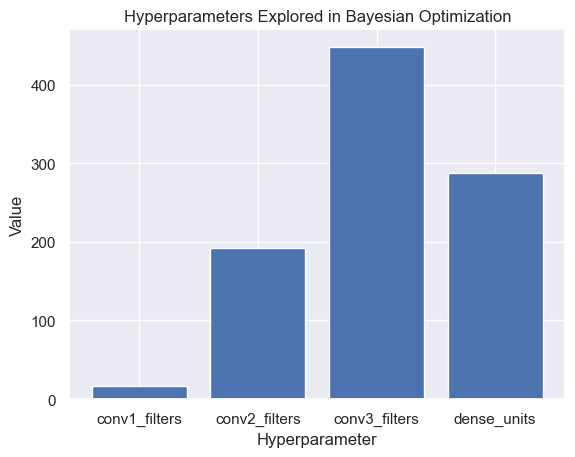

In [27]:
import matplotlib.pyplot as plt

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=10)[0]

# Access the hyperparameter values
conv1_filters = best_hyperparameters.get('conv1_filters')
conv2_filters = best_hyperparameters.get('conv2_filters')
conv3_filters = best_hyperparameters.get('conv3_filters')
dense_units = best_hyperparameters.get('dense_units')

# Create a bar chart to visualize the hyperparameters
hyperparameters = ['conv1_filters', 'conv2_filters','conv3_filters', 'dense_units']
values = [conv1_filters, conv2_filters, conv3_filters, dense_units]

plt.bar(hyperparameters, values)
plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.title('Hyperparameters Explored in Bayesian Optimization')
plt.show()


In [28]:
# import matplotlib.pyplot as plt

# # Train the model and store the history
# history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
# # history = tuner.results_summary()

# # Plot the accuracy and loss curves
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [29]:
predicted = best_model.predict(X_test)
predicted[:, :]

50/50 [==============================] - 2s 40ms/step


array([[1.0000000e+00, 1.2573604e-09],
       [8.8389003e-01, 1.1610999e-01],
       [9.9999869e-01, 1.2550031e-06],
       ...,
       [5.2255896e-06, 9.9999475e-01],
       [2.0725533e-04, 9.9979275e-01],
       [7.9667984e-08, 9.9999988e-01]], dtype=float32)

In [30]:
# Import confusion matrix and classification report from scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
Y_prediction = best_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(predicted,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(target[indexes_test], Y_pred_classes) 
print(classification_report(target[indexes_test], Y_pred_classes))

50/50 [==============================] - 2s 41ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       797
           1       0.97      0.98      0.98       797

    accuracy                           0.98      1594
   macro avg       0.98      0.98      0.98      1594
weighted avg       0.98      0.98      0.98      1594



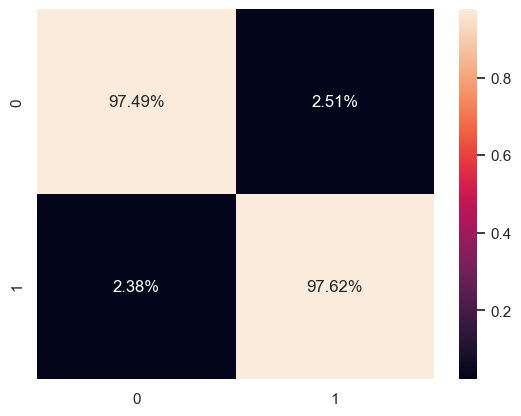

In [31]:
sns.heatmap(confusion_mtx/797, annot=True, fmt='.2%');

In [32]:
# Assume y_true and y_pred are the true and predicted labels for the test data, respectively
tn, fp, fn, tp = confusion_matrix(target[indexes_test], Y_pred_classes).ravel()

print(tn, fp, fn, tp)
specificity = tn / (tn + fp)
print(specificity)

777 20 19 778
0.9749058971141782


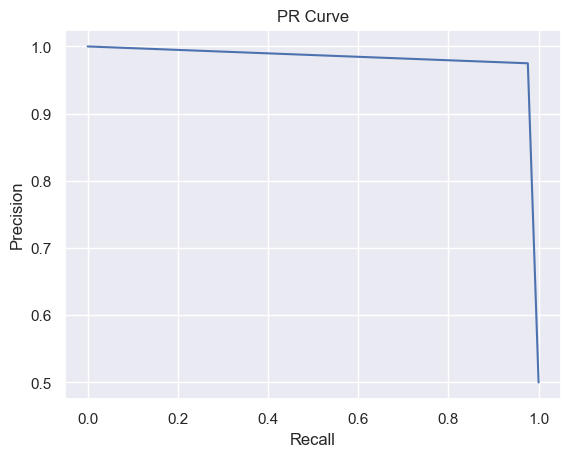

In [33]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assume y_true and y_score are the true labels and predicted scores for the test data, respectively
precision, recall, threshold = precision_recall_curve(target[indexes_test], Y_pred_classes)

# Plot the PR curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve') 
plt.show()

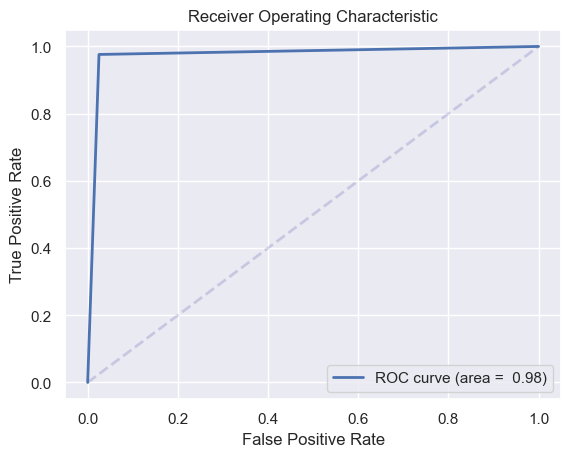

In [34]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(np.argmax(y_test, axis =1), np.argmax(predicted, axis =1), pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

lw = 2
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.15)
plt.plot(fpr, tpr, lw=lw, label=f'ROC curve (area = {roc_auc: 0.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [35]:
import matplotlib.pyplot as plt

# Retrieve the results of the hyperparameter search
tuner_results = tuner.results_summary()

if tuner_results is not None:
    # Get the hyperparameters and their corresponding values
    hyperparameters = tuner_results['hyperparameters']
    values = tuner_results['values']

    # Extract the metric values for evaluation (e.g., validation accuracy)
    metric = 'val_accuracy'
    metric_values = [trial[metric] for trial in values]

    # Plot the hyperparameters vs. metric values
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(metric_values)), metric_values, marker='o')
    plt.xticks(range(len(metric_values)), hyperparameters, rotation=45)
    plt.xlabel('Hyperparameters')
    plt.ylabel(metric)
    plt.title('Evaluation of Hyperparameters')
    plt.tight_layout()
    plt.show()
else:
    print("No tuner results available.")

Results summary
Results in path_to_directory\my_tuning_project_fold_5
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
conv1_filters: 16
conv2_filters: 192
conv3_filters: 448
dense_units: 288
dropout_rate: 0.4
learning_rate: 0.0001
Score: 0.9484764337539673

Trial 07 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 32
conv3_filters: 384
dense_units: 416
dropout_rate: 0.1
learning_rate: 0.001
Score: 0.9274238348007202

Trial 06 summary
Hyperparameters:
conv1_filters: 96
conv2_filters: 128
conv3_filters: 192
dense_units: 192
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.9263157844543457

Trial 05 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 192
conv3_filters: 384
dense_units: 352
dropout_rate: 0.4
learning_rate: 0.001
Score: 0.9218836426734924

Trial 02 summary
Hyperparameters:
conv1_filters: 128
conv2_filters: 256
conv3_filters: 192
dense_units: 96
dropout_rate: 0.30000000000000004
learning_rate: 0.001
Scor